In [1]:
# # 查看当前挂载的数据集目录
# !ls /home/aistudio/data/data1568/

<h2>1-引入库</h2>

In [1]:
import sys
import numpy as np

# import lr_utils
import matplotlib.pyplot as plt

import paddle
import paddle.fluid as fluid

%matplotlib inline

<h2>2-数据预处理</h2>

因为h5py在今天不好使，我就使用线下处理方式将h5py转换成npy<br/>
因而可直接用numpy处理

In [2]:
train_set_x_orig=np.load("/home/aistudio/data/data1568/traindata.npy")
train_set_y=np.load("/home/aistudio/data/data1568/trainlabel.npy")
test_set_x_orig=np.load("/home/aistudio/data/data1568/testdata.npy")
test_set_y=np.load("/home/aistudio/data/data1568/testlabel.npy")

In [3]:
#效果检验
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

print ("训练样本数: m_train = " + str(m_train))
print ("测试样本数: m_test = " + str(m_test))
print ("图片高度/宽度: num_px = " + str(num_px))
print ("图片大小: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练样本数: m_train = 5897
测试样本数: m_test = 2000
图片高度/宽度: num_px = 32
图片大小: (32, 32, 3)
train_set_x shape: (5897, 32, 32, 3)
train_set_y shape: (5897, 1)
test_set_x shape: (2000, 32, 32, 3)
test_set_y shape: (2000, 1)


In [4]:
###因为paddlepaddle认识的数据是3*l*h的，所以需要进行数据格式转换
###


train_set_x = np.array(train_set_x_orig).reshape(m_train, 3, num_px, num_px).astype(np.float32)
train_set_y = np.array(train_set_y).reshape(m_train, 1).astype(np.float32)
test_set_x = np.array(test_set_x_orig).reshape(m_test, 3, num_px, num_px).astype(np.float32)
test_set_y = np.array(test_set_y).reshape(m_test, 1).astype(np.float32)

In [5]:
#归一化
train_set_x=train_set_x/ 255.0 * 2.0 - 1.0

test_set_x=test_set_x/ 255.0 * 2.0 - 1.0

<h2>3-构造reader</h2>

In [6]:
# 读取训练数据或测试数据
def read_data(train_set_x,train_set_y,buffer_size):
 
    def reader():
     
        for i in xrange(buffer_size):            
            yield train_set_x[i,:], int(train_set_y[i])            
    return reader


<h2>4-使用卷积神经网络分类</h2>

In [7]:
def convolutional_neural_network():
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层
    Args:
        img -- 输入的原始图像数据
    Return:
        predict -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[3,32,32],dtype = 'float32')
    
    #第一个卷积层
    
#     hidden = fluid.nets.simple_img_conv_pool(input, num_filters, filter_size, pool_size, pool_stride, pool_padding=0)
    hidden=fluid.nets.simple_img_conv_pool(
    input=img,
        num_filters=20,
        filter_size=3,
        pool_size=2,
        pool_stride=1,
        pool_padding=0
    )
    
    drop_1=fluid.layers.dropout(hidden,0.4)
    
    #第二个卷积层
    
    h2=fluid.nets.simple_img_conv_pool(
    input=drop_1,
        num_filters=50,
        filter_size=3,
        pool_size=2,
        pool_stride=1,
        pool_padding=0
    )
    
    drop_2=fluid.layers.dropout(h2,0.4)

#     predict = fluid.layers.fc(h2,size=1,act='sigmoid')
    predict = fluid.layers.fc(drop_2,size=2,act='softmax')

    return predict

<h2>5-训练开始</h2>

In [8]:
# 设置训练场所
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

In [9]:
#配置网络结构
def train_func():
    
    label = fluid.layers.data(name='label', shape = [1],dtype = 'int64')
    predict = convolutional_neural_network()

    # 损失函数，cross_entropy 函数内部使用交叉熵损失函数
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    return avg_cost

In [10]:
def optimizer_func():
    # 创建优化器optimizer，下面列举了2种常用的优化器，不同类型优化器选一即可
    # 创建Momentum优化器，并设置学习率(learning_rate)、动量(momentum)
    optimizer=fluid.optimizer.Momentum(learning_rate=0.001,momentum=0.9)

    return optimizer

In [11]:
feed_order = ['img', 'label']     #数据格式
params_dirname = "./DNN_model"    #模型保存路径

In [12]:
# 事件处理函数
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 2 == 0: # 若干个batch,记录cost
            if event.metrics[0] < 10:
                plot_cost.append(train_title, step, event.metrics[0])
                plot_cost.plot()
        if event.step % 20 == 0: # 若干个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)
            if test_metrics[0] < 10:
                plot_cost.append(test_title, step, test_metrics[0])
                plot_cost.plot()

#             if test_metrics[0] < 1.0:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 10.0, stop')
#                 trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)
    step += 1

In [13]:
#训练所用到的具体数据
BATCH_SIZE=50
# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(train_set_x,train_set_y,buffer_size=209), 
        buf_size=60),
    batch_size=BATCH_SIZE)
# 设置测试reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(test_set_x,test_set_y,buffer_size=50), 
        buf_size=60),
    batch_size=BATCH_SIZE)

In [14]:
#创建训练器
trainer = fluid.Trainer(
    train_func= train_func,
    place= place,
    optimizer_func= optimizer_func)


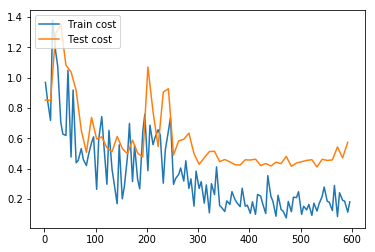

<Figure size 432x288 with 0 Axes>

In [15]:
#开始训练
trainer.train(
    reader=train_reader,
    num_epochs=60 ,
    event_handler=event_handler_plot ,
    feed_order=feed_order )

<h2>预测</h2>

In [16]:
inferencer = fluid.Inferencer(
    infer_func=convolutional_neural_network, param_path=params_dirname, place=place)

In [17]:
# 取出一个 mini-batch
for mini_batch in test_reader(): 
    # 转化为 numpy 的 ndarray 结构，并且设置数据类型
    test_x = np.array([data[0] for data in mini_batch]).astype("float32")
    test_y = np.array([data[1] for data in mini_batch]).astype("int64")
    # 真实进行预测
    mini_batch_result = inferencer.infer({'img': test_x})
    
#     result=(mini_batch_result[0][:,-1]>0.5)+0   #True or False 转0/1，直接后面+0即可
    
    
    # 打印预测结果
    mini_batch_result = np.argsort(mini_batch_result) #找出可能性最大的列标，升序排列,
    
    ###目的是啥啊，为啥升序排列啊
    ###经过分析，这是多分类问题会用到的函数，找出概率值最大的下标
    
    
    mini_batch_result = mini_batch_result[0][:, -1]  #把这些列标拿出来

#     print('预测结果：%s'%result)
    print('预测结果：%s'%mini_batch_result)
    
    # 打印真实结果    
    label = np.array(test_y) # 转化为 label
    print('真实结果：%s'%label)
    break    

预测结果：[1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 0 0 1 0 0 1 1 1 1 0 1 0]
真实结果：[1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1
 1 0 1 1 0 0 1 1 1 0 1 0 1]


In [18]:
# 查看百分比
def right_ratio(right_counter, total):
    ratio = float(right_counter)/total
    return ratio

In [19]:
# 评估函数 data_set 是一个reader
def evl(data_set):
    total = 0    #操作的元素的总数
    right_counter = 0  #正确的元素

    pass_num = 0
#     print(liruoyi)
    for mini_batch in data_set():
        pass_num += 1
        #预测
        test_x = np.array([data[0] for data in mini_batch]).astype("float32")
        test_y = np.array([data[1] for data in mini_batch]).astype("int64")
        mini_batch_result = inferencer.infer({'img': test_x})
        
#         mini_batch_result=(mini_batch_result[0][:,-1]>0.5)+0   #True or False 转0/1，直接后面+0即可
        
        #预测的结果
        mini_batch_result = np.argsort(mini_batch_result) #找出可能性最大的列标，升序排列
        mini_batch_result = mini_batch_result[0][:, -1]+0  #把这些列标拿出来

#         print('预测结果：%s'%result)

        label = np.array(test_y) # 转化为 label
#         print('真实结果：%s'%label)

        #计数
        label_len = len(label)
        total += label_len
        for i in xrange(label_len):
            if mini_batch_result[i] == label[i]:
                right_counter += 1

    ratio = right_ratio(right_counter, total)
    return ratio

In [20]:
ratio = evl(train_reader)
print('训练数据的正确率 %0.2f%%'%(ratio*100))

ratio = evl(test_reader)
print('预测数据的正确率 %0.2f%%'%(ratio*100))


训练数据的正确率 98.50%
预测数据的正确率 80.00%
